In [15]:
########### Importation ###########

import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate as inter
from scipy.integrate import odeint

In [61]:
########### Functions ###########

def interpolationSpline(X, Y):
    tck = inter.splrep(X, Y, k=3)

    def s(x):
        return inter.splev(x, tck)
    return s


def interpolationDfDiv(X, Y):
    n = len(X)
    df = Y.copy()
    for i in range(n):
        for j in range(n - 1, i, -1):
            df[j] = (df[j] - df[j - 1]) / (X[j] - X[j - i - 1])
            
            
    def g(x):
        res = df[0]
        for k in range(1, n):
            p = 1
            for j in range(k):
                p *= (x - X[j])
            res += df[k] * p
        return res
    return g


def Derivation(P):
    p = len(P)
    if p == 1:
        return [0]
    else:
        return [i * P[i] for i in range(1, p)]


def integrateur(f, a, b, n):
    integral = 0
    for k in range(n + 1):
        integral = integral + f(k * (b - a) / n) * (b - a) / n
    return integral


def average(f, a, b):
    return integrateur(f, a, b, 10000) / (b - a)


def derivative(f, x, epsilon=1e-6):
    eps = epsilon / 2
    def g(x):
        return (f(x + eps) - f(x - eps)) / epsilon
    return g(x)

In [64]:
########### Main code ###########

with open('covid.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    data = []
    for row in csv_reader:
        data.append([int(e) for e in row])
data = np.asarray(data)
S0 = int(input("Initial number of suspect cases: "))
temps = data[:, 0]
I = np.cumsum(data[:, 1])
cas = I + np.cumsum(data[:, 2])
S = S0 - cas
E = []
tempsE = list(temps)
tempsE.pop()
for i in range(len(temps) - 1):
    E.append(cas[(np.abs(temps - temps[i] - 10)).argmin()] - cas[i])
E = np.asarray(E)

# Data reduction

tempsRed = [temps[0]]
tempsERed = [tempsE[0]]
IR = [I[0]]
SR = [S[0]]
ER = [E[0]]
for i in range(1, len(tempsE)):
    if tempsE[i] - tempsRed[-1] >= 25:
        tempsRed.append(tempsE[i])
        tempsERed.append(tempsE[i])
        IR.append(I[i])
        SR.append(S[i])
        ER.append(E[i])
if tempsERed[-1] != tempsE[-1]:
    tempsERed.append(tempsE[-1])
    ER.append(E[-1])
tempsRed.append(temps[-1])
IR.append(I[-1])
SR.append(S[-1])


XI = interpolationSpline(tempsRed, IR)
XS = interpolationSpline(tempsRed, SR)
XE = interpolationSpline(tempsERed, ER)

didt = lambda t: derivative(XI, t)
dsdt = lambda t: derivative(XS, t)
dedt = lambda t: derivative(XE, t)

beta = lambda t: -(dsdt(t)) / (XS(t) * XI(t))
alpha = lambda t: -(dsdt(t) + dedt(t)) / XE(t)
beta = average(beta, temps[0], temps[-1])
gamma_sir = lambda t: -(didt(t) + dsdt(t)) / XI(t)
gamma_seir = lambda t: -(dsdt(t) + dedt(t) + didt(t)) / XI(t)
alpha = average(alpha, temps[0], temps[-1])
gamma_sir = average(gamma_sir, temps[0], temps[-1])
gamma_seir = average(gamma_seir, temps[0], temps[-1])


# Fonction du système différentiel SIR

def f_sir(s, t, beta, gamma, mu):
    S = s[0]
    I = s[1]
    R = s[2]
    dSdt = -beta * S * I
    dIdt = beta * S * I - (gamma + mu) * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


# Fonction du système différentiel SIR

def f_seir(s, t, beta, gamma, alpha, mu):
    S = s[0]
    E = s[1]
    I = s[2]
    R = s[3]
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - (gamma + mu) * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

Initial number of suspect cases: 10000000


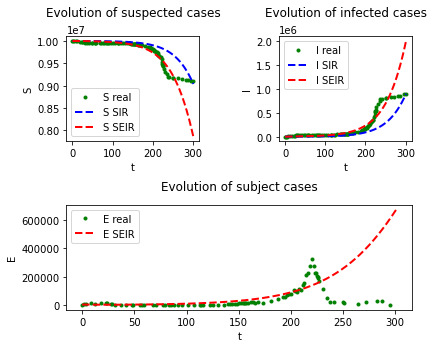

In [65]:
######## Plotting results #########

t = np.linspace(temps[0], temps[-1], 100000)
s0_sir = [S[0], I[0], 0]
s_sir = odeint(f_sir, s0_sir, t, (beta, gamma_sir, 0))
s0_seir = [S[0], E[0], I[0], 0]
s_seir = odeint(f_seir, s0_seir, t, (beta, gamma_seir, alpha, 0))

ax = plt.subplot(221)
ax.set_title('Evolution of suspected cases', pad=20)
ax.plot(temps, S, 'g.')
ax.plot(t, s_sir[:, 0], 'b--', linewidth=2.0)
ax.plot(t, s_seir[:, 0], 'r--', linewidth=2.0)
ax.set_xlabel("t")
ax.set_ylabel("S")
ax.legend(['S real', 'S SIR', 'S SEIR'])
ax = plt.subplot(222)

ax.set_title('Evolution of infected cases', pad=20)
ax.plot(temps, I, 'g.')
ax.plot(t, s_sir[:, 1], 'b--', linewidth=2.0)
ax.plot(t, s_seir[:, 2], 'r--', linewidth=2.0)
ax.set_xlabel("t")
ax.set_ylabel("I")
ax.legend(['I real', 'I SIR', 'I SEIR'])
ax = plt.subplot(212)
ax.set_title('Evolution of subject cases', pad=15)
ax.plot(tempsE, E, 'g.')
ax.plot(t, s_seir[:, 1], 'r--', linewidth=2.0)
ax.set_xlabel("t")
ax.set_ylabel("E")
ax.legend(['E real', 'E SEIR'])

# set the spacing between subplots

plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=0.9, 
                    top=1, 
                    wspace=0.6, 
                    hspace=0.6)

plt.show()

#Initial number of suspect cases should be > 100000 for a better prediction